In [59]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

# Initial setup

In [61]:
mpl.rcParams['image.cmap'] = 'gray'

In [62]:
x_train, y_train, x_valid, y_valid = get_data()

In [63]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [64]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [65]:
model = Model(m, nh, 10)

In [66]:
pred = model(x_train)

# Cross entropy loss
= nll of softmax

e^x / sum of e^x

In [67]:
def log_softmax(x):
    return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

In [68]:
sm_pred = log_softmax(pred)

In [69]:
sm_pred.shape

torch.Size([50000, 10])

$$ -\sum x\, \log p(x) $$

since xs are 1hot encoded, can be rewritten as $$-log(pi)$$

In [70]:
y_train[:3]

tensor([5, 0, 4])

In [71]:
# [0, 5] [1, 0], [2, 4]
sm_pred[[0, 1, 2], [5, 0, 4]]

tensor([-2.5534, -2.3999, -2.1719], grad_fn=<IndexBackward>)

In [72]:
y_train.shape[0]

50000

In [73]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

In [74]:
loss = nll(sm_pred, y_train)

In [75]:
loss

tensor(2.3023, grad_fn=<NegBackward>)

# Loss is a benchmark for comparison

$$log(\frac{a}{b}) = log(a) - log(b)$$

In [76]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [77]:
test_near(nll(log_softmax(pred), y_train), loss)

log of the sum of exponential 

$$ \log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$


In [78]:
def logsumexp(x):
    # replace x.exp().sum(-1, keepdim=True).log()
    m = x.max(-1)[0]
    return m + (x-m[:, None]).exp().sum(-1).log()

In [79]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [80]:
# use it for our log_softmax
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [81]:
# pytorch implementation
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In [82]:
test_near(F.cross_entropy(pred, y_train), loss)

# Basic training loop

- get the output on a batch of inputs
- compare the output to the labels and compute a loss
- calculate the gradients of the loss with respect to every parameter of model
- update said parameters with those gradients 

In [83]:
loss_func = F.cross_entropy

In [84]:
#export 
def accuracy(out, yb):
    return (torch.argmax(out, dim=1)==yb).float().mean()

In [85]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.0380,  0.1300, -0.0252,  0.0227,  0.0842, -0.2060,  0.0716,  0.2446,
          0.0605,  0.0416], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [86]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3057, grad_fn=<NllLossBackward>)

In [87]:
accuracy(preds, yb)

tensor(0.0781)

In [90]:
lr = 0.5
epochs = 1

In [91]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad*lr
                    l.bias -= l.bias.grad*lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [92]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1559, grad_fn=<NllLossBackward>), tensor(0.9375))

# Using parameters and optim
use nn.Module.__setattr__ and move relu to functional

In [93]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x): 
        return self.l2(F.relu(self.l1(x)))

In [94]:
model = Model(m, nh, 10)

In [95]:
for name, l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [96]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [97]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [104]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                # can automatically update parameters
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [105]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0264, grad_fn=<NllLossBackward>), tensor(1.))

Pytorch overrides setattr function in nn.Module so the submodules you define are registered as parameters of model

In [108]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        # create attributes
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
    
    def __repr__(self):
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [109]:
mdl = DummyModule(m, nh, 10)

In [110]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

# Registering moduels
we can use original layers approach, but we have to register the modules

In [111]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [112]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):
            self.add_module(f'layer_{i}', l)
    
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [113]:
model = Model(layers)

In [114]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

# nn.ModuleList
does the same thing

In [118]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [119]:
model = SequentialModel(layers)

In [120]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

# nn.Sequential 
does the above

In [122]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [123]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1846, grad_fn=<NllLossBackward>), tensor(0.9375))

In [125]:
#nn.Sequential??
#def forward(self, input):
#        for module in self._modules.values():
#            input = module(input)
#        return input

In [126]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## Optim

replcae

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```    
and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [127]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * lr
    
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [129]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
opt = Optimizer(model.parameters())

In [130]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [132]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.1879, grad_fn=<NllLossBackward>), tensor(0.9375))

# model to contain it all

In [136]:
#export
from torch import optim

In [137]:
optim.SGD.step??

Signature: optim.SGD.step(self, closure=None)
Source:   
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['mome

In [138]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [139]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.3050, grad_fn=<NllLossBackward>)

In [140]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i : end_i]
        yb = y_train[start_i : end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [142]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0244, grad_fn=<NllLossBackward>), tensor(1.))

In [143]:
assert acc > 0.7

# Dataset and DataLoader

In [144]:
#export 
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [145]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [146]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5, )
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [147]:
model, opt = get_model()

In [148]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb, yb = train_ds[i*bs:i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [149]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.0913, grad_fn=<NllLossBackward>), tensor(0.9375))

# Dataloader

replace the loop
```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
```
with a clean dataloader
```python
for xb, yb in train_dl:
```

In [150]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [151]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [152]:
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs, 28*28)
assert yb.shape == (bs, )

tensor(3)

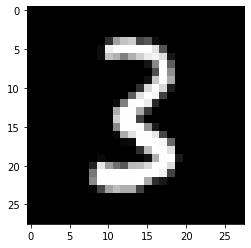

In [153]:
plt.imshow(xb[0].view(28, 28))
yb[0]

In [154]:
model, opt = get_model()

In [155]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            

In [156]:
fit()

In [157]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.1327, grad_fn=<NllLossBackward>), tensor(0.9844))

# Random sampling
random order, differ each iteration

In [164]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
    
    def __iter__(self):
        # random n
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        # return n batch
        for i in range(0, self.n, self.bs):
            yield self.idxs[i:i+self.bs]

In [165]:
small_ds = Dataset(*train_ds[:10])

In [166]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [167]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([3, 5, 9]), tensor([8, 6, 0]), tensor([2, 7, 1]), tensor([4])]

In [168]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

# put sampler into data loader
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [169]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [170]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

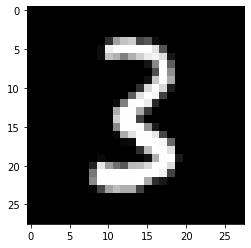

In [171]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28, 28))

In [172]:
model, opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1984, grad_fn=<NllLossBackward>), tensor(0.9375))

# Pytorch DataLoader

In [175]:
#export 
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [178]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=RandomSampler(valid_ds), collate_fn=collate)

In [181]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0572, grad_fn=<NllLossBackward>), tensor(1.))

PyTorch default work fine for most things however

In [184]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [185]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.1984, grad_fn=<NllLossBackward>), tensor(0.9375))

# Validation
calcualte and print validation loss at the end of each epoch

In [186]:
# dataloader = xb, yb
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # handle batchnorm / dropout
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [187]:
#export 
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
           DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [188]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1373) tensor(0.9605)
1 tensor(0.1181) tensor(0.9671)
2 tensor(0.5836) tensor(0.8502)
3 tensor(0.0969) tensor(0.9725)
4 tensor(0.1023) tensor(0.9676)


In [189]:
assert acc>0.9

# Export

In [190]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp/nb_03.py
